In [2]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.linalg import eigh

### TASK 1: Building a FL Network

In [4]:
def generate_FL_network(n_stations):
    np.random.seed(42)

    # Generate random metadata for each station (latitude, longitude, temperature stats)
    station_data = pd.DataFrame({
        "latitude": np.random.uniform(60, 65, n_stations),
        "longitude": np.random.uniform(24, 30, n_stations),
        "temperature_mean": np.random.uniform(-10, 20, n_stations),
        "temperature_std": np.random.uniform(1, 5, n_stations)
    })

    G = nx.Graph()

    for idx, row in station_data.iterrows():

        # Simulate a dataset of 100 temperature values with Gaussian distribution
        local_dataset = np.random.normal(loc=row['temperature_mean'], scale=row['temperature_std'], size=100)
        G.add_node(idx, lat=row['latitude'], lon=row['longitude'], dataset=local_dataset)

    return G, station_data

n_stations = 10
G_geo, geo_station_data = generate_FL_network(n_stations)
G_stat, stat_station_data = generate_FL_network(n_stations)

In [5]:
def test_generate_FL_network(test_n_stations):
    G, station_data = generate_FL_network(n_stations=test_n_stations)

    assert len(G.nodes) == test_n_stations, "Number of nodes in the FL network is incorrect"

    for i in G.nodes():
        assert 'lat' in G.nodes[i], "Latitude missing from node metadata"
        assert 'lon' in G.nodes[i], "Longitude missing from node metadata"
        assert 'dataset' in G.nodes[i], "Dataset missing from node metadata"

        assert isinstance(G.nodes[i]['dataset'], np.ndarray), "Dataset is not a numpy array"
        assert G.nodes[i]['dataset'].shape == (100,), "Dataset shape is incorrect"

        dataset = G.nodes[i]['dataset']
        sample_mean = np.mean(dataset)
        sample_std = np.std(dataset, ddof=0)
        
        expected_mean = station_data.loc[i, 'temperature_mean']
        expected_std = station_data.loc[i, 'temperature_std']
        
        # Tolerance due to random sampling
        assert np.isclose(sample_mean, expected_mean, atol=1.0), \
            f"Node {i}: Mean mismatch. Expected {expected_mean}, got {sample_mean}"
        assert np.isclose(sample_std, expected_std, atol=1.0), \
            f"Node {i}: Std deviation mismatch. Expected {expected_std}, got {sample_std}"

test_n_stations = 10
test_generate_FL_network(test_n_stations)

### TASK 2: Construct Edges in the FL Network

In [6]:
def construct_edges(G, station_data, method):
    """
    Constructs edges in the graph by connecting each node to its 5 nearest neighbors.
    'geo': Uses latitude and longitude to compute distances.
    'stat': Uses temperature mean and standard deviation to compute distances.
    """
    
    n = len(G.nodes)
    
    if method == 'geo':
        coords = station_data[['latitude', 'longitude']].values
    else:
        coords = station_data[['temperature_mean', 'temperature_std']].values  

    # Compute pairwise distances between all nodes
    dist_matrix = distance_matrix(coords, coords)

    for i in range(n):

        # Take the 5 closest nodes and add an edge with distance as weight
        nearest_neighbors = np.argsort(dist_matrix[i])[1:6]
        for j in nearest_neighbors:
                G.add_edge(i, j, weight=dist_matrix[i, j])

    return G

G_geo = construct_edges(G_geo, geo_station_data, method='geo')
G_stat = construct_edges(G_stat, stat_station_data, method='stat')

In [7]:
def test_construct_edges():
    G, station_data = generate_FL_network(n_stations=10)
    G = construct_edges(G, station_data, method='geo')

    # Each node should have minimum 5 neighbors
    for i in G.nodes():
        assert len(list(G.neighbors(i))) >= 5, f"Node {i} does not have 5 neighbors"

    # Ensure bidirectional edges exist
    for i, j in G.edges():
        assert G.has_edge(j, i), f"Edge ({j}, {i}) is missing"

    # Check total number of edges
    assert len(G.edges()) >= (5 * 10) / 2, "Total number of edges is incorrect"

test_construct_edges()

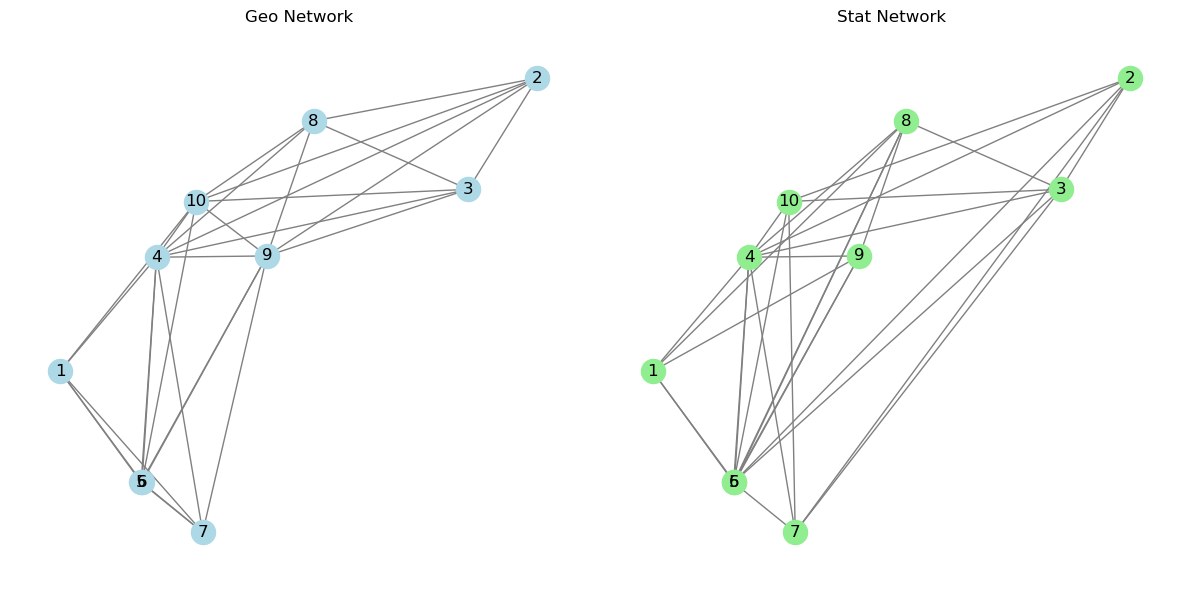

In [8]:
# Relabel nodes for both networks so that they start from 1 instead of 0
G_geo_relabel = nx.relabel_nodes(G_geo, {i: i+1 for i in G_geo.nodes()})
G_stat_relabel = nx.relabel_nodes(G_stat, {i: i+1 for i in G_stat.nodes()})

# This ensures that node 1, node 2, etc. appear at the same locations in both visualizations
common_pos = {i+1: (geo_station_data.loc[i, "longitude"], geo_station_data.loc[i, "latitude"]) 
              for i in range(len(geo_station_data))}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

nx.draw(G_geo_relabel, pos=common_pos, ax=ax1, with_labels=True, node_color='lightblue', edge_color='gray')
ax1.set_title("Geo Network")
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")

nx.draw(G_stat_relabel, pos=common_pos, ax=ax2, with_labels=True, node_color='lightgreen', edge_color='gray')
ax2.set_title("Stat Network")
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")

plt.tight_layout()
plt.show()

### TASK 3: Analyze Federated Learning (FL) Network Connectivity

In [10]:
def analyze_network(G):
    degrees = [G.degree(n) for n in G.nodes()]
    
    # Laplacian matrix
    L = nx.laplacian_matrix(G).toarray()
    eigvals, eigvecs = eigh(L)    

    if len(eigvals) > 1:
        # Second smallest eigenvalue and corresponding eigenvector
        v2 = eigvecs[:, 1]

        plt.figure(figsize=(10, 5))
        plt.bar(range(1, len(degrees) + 1), degrees)
        plt.xlabel("Node Index")
        plt.ylabel("Degree")
        plt.title("Node Degrees")
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(v2) + 1), v2, marker="o")
        plt.xlabel("Node Index")
        plt.ylabel("Eigenvector Entry")
        plt.title("Fiedler Eigenvector")
        plt.show()
    else:
        print("Not enough connected nodes to compute the second smallest eigenvalue.")

Analyzing network structure for geo-based graph:


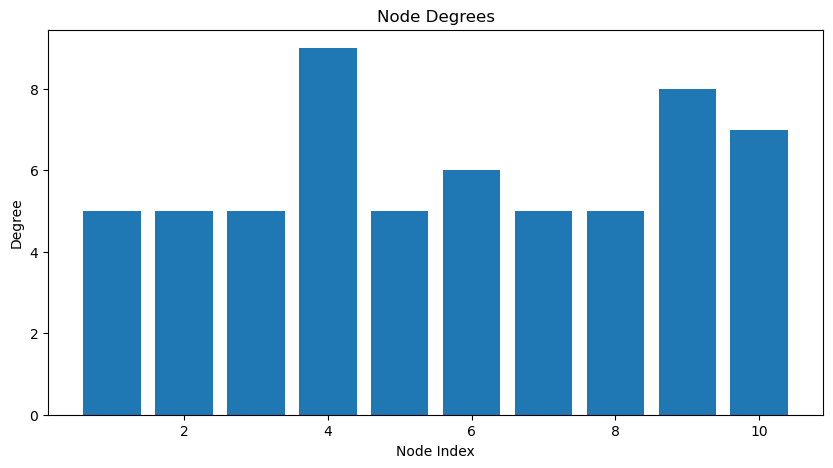

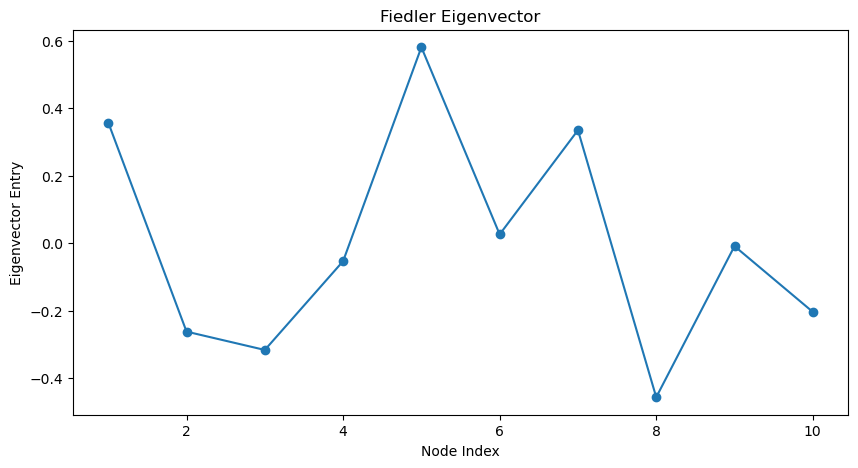

In [11]:
print("Analyzing network structure for geo-based graph:")
analyze_network(G_geo)

Analyzing network structure for statistics-based graph:


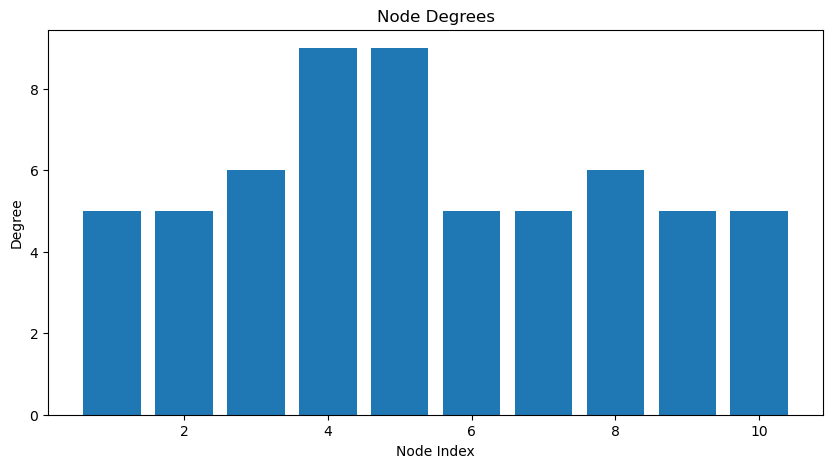

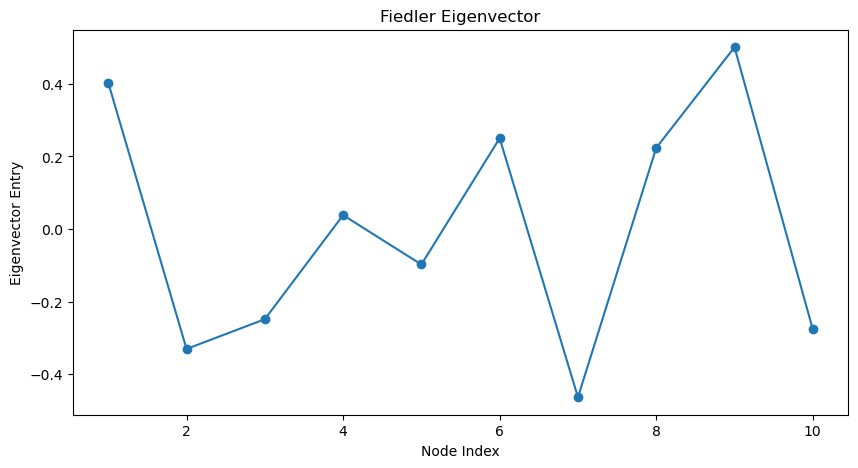

In [12]:
print("Analyzing network structure for statistics-based graph:")
analyze_network(G_stat)

### TASK 4: Local Averaging for Federated Learning

In [13]:
def local_averaging(G):
    prediction_errors = {}

    for i in G.nodes():
        neighbors = list(G.neighbors(i))
        if neighbors:
            avg_temp_pred = np.mean([np.mean(G.nodes[j]['dataset']) for j in neighbors])
        else:
            avg_temp_pred = np.mean(G.nodes[i]['dataset'])
        
        avg_temp_actual = np.mean(G.nodes[i]['dataset'])
        prediction_errors[i] = avg_temp_pred - avg_temp_actual
    
    return prediction_errors

prediction_errors_geo = local_averaging(G_geo)
prediction_errors_stat = local_averaging(G_stat)

results_df = pd.DataFrame({
    "Geo-Based Error": list(prediction_errors_geo.values()),
    "Stat-Based Error": list(prediction_errors_stat.values())
}, index=list(G_geo.nodes()))

print(results_df)

   Geo-Based Error  Stat-Based Error
0        -7.107389         -1.694677
1         6.848141          3.706773
2         1.432471         -0.307620
3         0.966413          0.966413
4         2.637288         -0.904123
5       -12.469832         -8.533987
6        11.270813          2.063615
7        -6.606044          0.073781
8        -8.270796         -2.431390
9        12.844463          7.058151


In [14]:
def test_local_averaging():
    G, station_data = generate_FL_network(n_stations=10)
    G = construct_edges(G, station_data, method='geo')

    prediction_errors = local_averaging(G)

    assert len(prediction_errors) == 10, "Prediction error missing for some nodes"

    for i, error in prediction_errors.items():
        assert isinstance(error, float), f"Prediction error for node {i} is not a float"

test_local_averaging()